<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/7. FNO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 불러오기

In [ ]:
!wget https://github.com/sjoon0305/KSME2026/raw/main/b.model_FNO.pth

!wget https://github.com/sjoon0305/KSME2026/raw/main/c.ns_data.mat

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

In [ ]:
data = scipy.io.loadmat("ns_data.mat")
v = data['a']       # numpy array, shape: (N, s, s)
u = data['u']       # numpy array, shape: (N, s, s, record_steps)
t = data['t']  # numpy array, shape: (record_steps,) 또는 (record_steps,1)
t = np.array(t).flatten()  # (record_steps,)

print(v.shape)
print(u.shape)
print(t.shape)

(20, 256, 256)
(20, 256, 256, 200)
(200,)


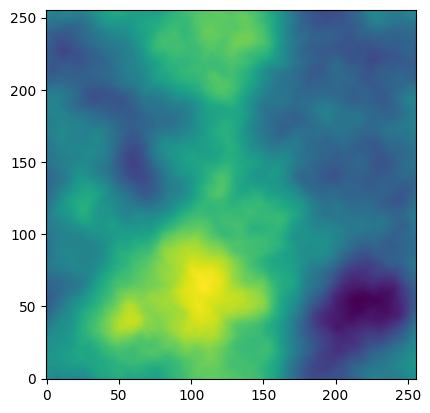

In [3]:
plt.imshow(v[0], origin='lower' )

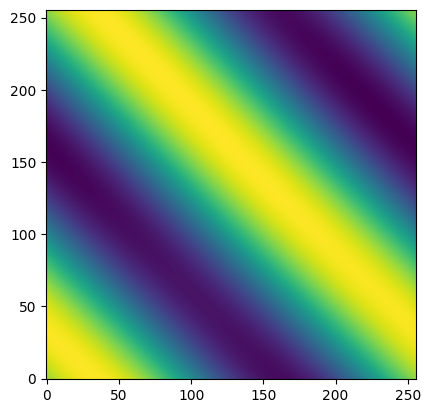

In [4]:
t=150
plt.imshow(u[0,:,:,t], origin='lower' )

In [5]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np
# for idx in range(20):

#     # u: shape (1, H, W, 200) 라고 가정
#     fig, ax = plt.subplots()
#     img = ax.imshow(u[idx, :, :, 0], origin='lower')
#     ax.axis('off')  # 축 제거

#     def update(t):
#         img.set_data(u[idx, :, :, t])
#         return [img]

#     ani = animation.FuncAnimation(fig, update, frames=200, interval=50, blit=True)

#     # GIF 저장
#     ani.save(f"data_gif/output_{idx}.gif", writer='pillow', fps=20)

#     plt.close()
#     if idx % 5 == 0:
#         print(idx)


샘플 시각화

데이터 처리

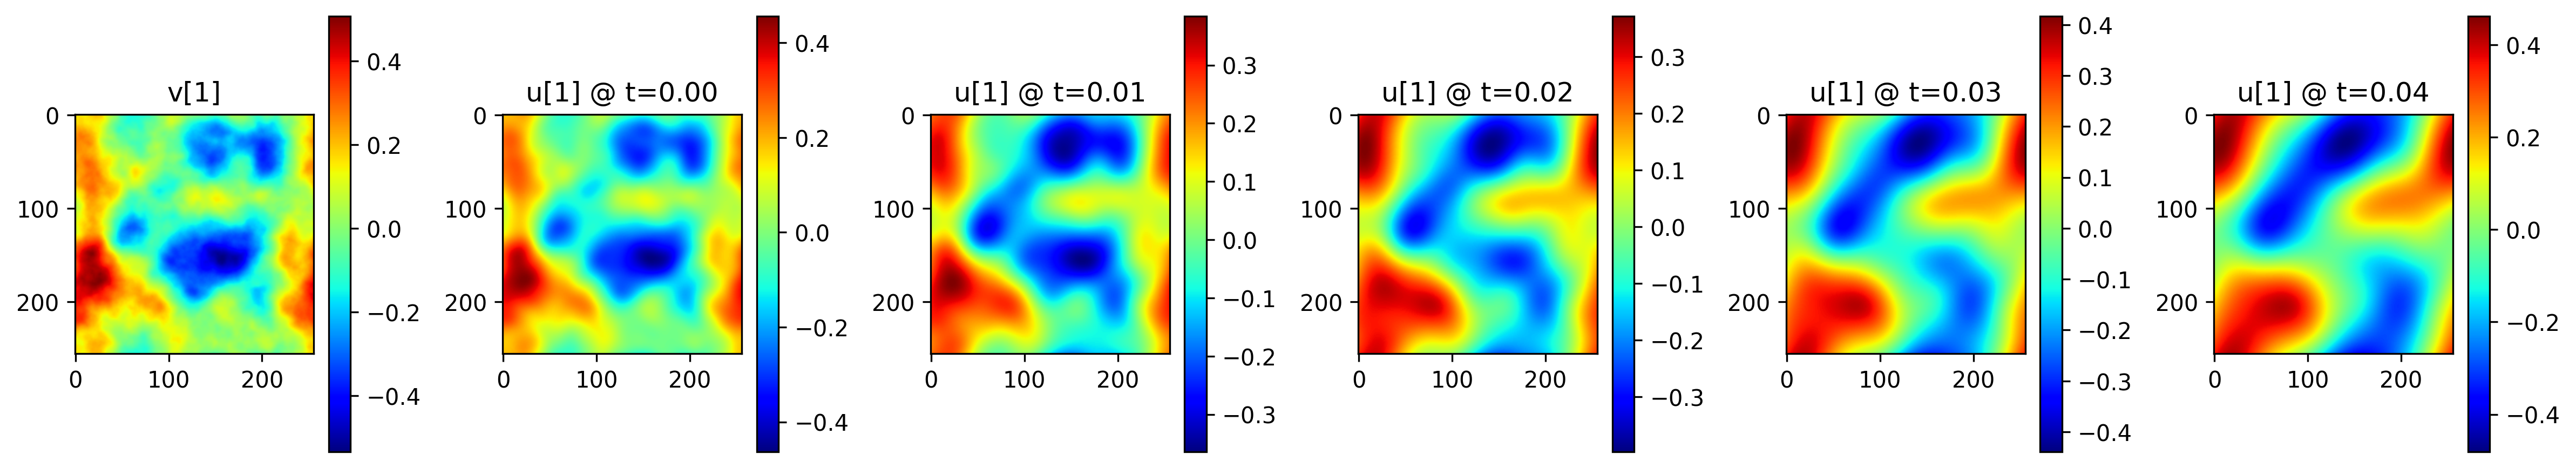

In [6]:
# 0. 시간 배열이 제대로 정의되어 있어야 함
t = np.linspace(0, 1, u.shape[3])  # 예: 200개의 시간 프레임

# 1. 샘플 번호와 시간 프레임 인덱스
sample_idx = 1

time_indices = [0, 2, 4, 6, 8]  # 각 시간 프레임 인덱스

# 2. 시각화
plt.figure(figsize=(16, 3), dpi=300)

# a: 초기 상태 (v)
plt.subplot(1, 6, 1)
plt.imshow(v[sample_idx], cmap='jet')
plt.colorbar()
plt.title(f"v[{sample_idx}]")

# b: 시간 경과 후 상태 (u)
for i, tidx in enumerate(time_indices):
    plt.subplot(1, 6, i + 2)
    plt.imshow(u[sample_idx, :, :, tidx], cmap='jet')
    plt.colorbar()
    plt.title(f"u[{sample_idx}] @ t={t[tidx]:.2f}")

plt.tight_layout()
plt.show()


In [7]:
# 입력 초기 조건 + 공간 좌표를 결합하기 위해 차원 확장
# vorticity: (N, s, s) --> (N, s, s, 1)
v = v[..., np.newaxis]

# u는 Navier–Stokes 해 전체를 사용 (shape: (N, s, s, record_steps))
N, s, _, record_steps = u.shape  # record_steps: 타깃 시점 수

# 공간 좌표 생성 (0~1로 정규화)
gridx = np.linspace(0, 1, s)
gridy = np.linspace(0, 1, s)
gridx, gridy = np.meshgrid(gridx, gridy, indexing='ij')  # (s, s)
grid = np.stack([gridx, gridy], axis=-1)  # (s, s, 2)
grid = np.expand_dims(grid, axis=0)         # (1, s, s, 2)
grid = np.repeat(grid, N, axis=0)           # (N, s, s, 2)

# 최종 입력: [v, grid] → (N, s, s, 3)
x_data = np.concatenate([v, grid], axis=-1)  # Input Function a
y_data = u.copy()  # (N, s, s, record_steps) # Output Function u

print("x_data shape:", x_data.shape)
print("y_data shape:", y_data.shape)

x_data shape: (20, 256, 256, 3)
y_data shape: (20, 256, 256, 200)


학습/테스트셋 분할

In [8]:
# 학습/테스트셋 분할 (30% / 70%)
N_total = x_data.shape[0]
N_train = int(0.3 * N_total)
x_train = torch.tensor(x_data[:N_train], dtype=torch.float32)
y_train = torch.tensor(y_data[:N_train], dtype=torch.float32)
x_test = torch.tensor(x_data[N_train:], dtype=torch.float32)
y_test = torch.tensor(y_data[N_train:], dtype=torch.float32)

# DataLoader 구성
batch_size = 4
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

FNO 구조

In [9]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # 사용할 Fourier 모드 수 (세로)
        self.modes2 = modes2  # (가로)
        self.scale = 1 / (in_channels * out_channels)
        # 복소수 weight parameters
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # input: (batch, in_channel, x, y), weights: (in_channel, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        '''
        x_ft = torch.fft.rfft2(x)                      # ℱ: 주파수 영역 변환
        out_ft[:, :, :m1, :m2] = compl_mul2d(...)      # R: 주파수 영역 (양의 주파수)
        out_ft[:, :, -m1:, :m2] = compl_mul2d(...)     # R: 주파수 영역 (음의 주파수)
        x = torch.fft.irfft2(out_ft, s=(H, W))         # ℱ⁻¹: 공간으로 역변환
        '''
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x)  # (batch, in_channels, H, W//2+1), complex tensor
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2+1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, out_channels):
        super(FNO2d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width   # Latent Space Dimension
        self.out_channels = out_channels  # record_steps
        self.padding = 9  # pad if non-periodic
        self.fc0 = nn.Linear(3, self.width)  # input channel = 3: (a, x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.out_channels)  # output channel = record_steps

    def forward(self, x):
        # x: (batch, s, s, 3)
        # grid 정보는 이미 x에 포함되어 있음
        x = self.fc0(x)  # (batch, s, s, width)
        x = x.permute(0, 3, 1, 2)  # (batch, width, s, s)
        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = self.fc1(x.permute(0,2,3,1))
        x = F.gelu(x)
        x = self.fc2(x)
        return x  # (batch, s, s, out_channels)

class Net2d(nn.Module):
    def __init__(self, modes, width, out_channels):
        super(Net2d, self).__init__()
        self.block = FNO2d(modes, modes, width, out_channels)
    def forward(self, x):
        return self.block(x)
    def count_params(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

모델 정의

In [10]:
modes1 = 12 # Cut off Frequency
modes2 = 12 # Cut off Frequency
width = 128 # Latent Vector Size

# 전체 시간에 대한 해를 사용
out_channels = u.shape[-1]

model = Net2d(modes1, width, out_channels).cuda()
print("FNO 모델 파라미터 수:", model.count_params())
learning_rate = 0.001
epochs = 1000
step_size = 20
gamma = 0.5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * (N_train // batch_size))
loss_fn = nn.MSELoss()

FNO 모델 파라미터 수: 18983240


학습

In [11]:
def train_model(model, optimizer, scheduler, train_loader, test_loader, epochs):
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()  # x: (batch, s, s, 3), y: (batch, s, s, record_steps)
            optimizer.zero_grad()
            out = model(x)  # (batch, s, s, record_steps)
            loss = loss_fn(out.view(x.size(0), -1), y.view(x.size(0), -1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                out = model(x)
                test_loss += loss_fn(out.view(x.size(0), -1), y.view(x.size(0), -1)).item()
        print(f"Epoch {ep}: Train Loss = {train_loss/len(train_loader):.6f}, Test Loss = {test_loss/len(test_loader):.6f}, Time = {default_timer()-t1:.2f}s")
    return model

model_FNO = train_model(model, optimizer, scheduler, train_loader, test_loader, epochs)

Epoch 0: Train Loss = 1.024912, Test Loss = 1.042032, Time = 1.10s
Epoch 1: Train Loss = 1.024659, Test Loss = 1.041194, Time = 0.44s
Epoch 2: Train Loss = 1.024532, Test Loss = 1.040415, Time = 0.49s
Epoch 3: Train Loss = 1.023132, Test Loss = 1.039457, Time = 0.52s
Epoch 4: Train Loss = 1.015346, Test Loss = 1.035590, Time = 0.52s
Epoch 5: Train Loss = 1.007006, Test Loss = 1.017201, Time = 0.51s
Epoch 6: Train Loss = 0.909937, Test Loss = 0.956616, Time = 0.51s
Epoch 7: Train Loss = 0.721819, Test Loss = 0.902727, Time = 0.51s
Epoch 8: Train Loss = 0.501440, Test Loss = 0.718672, Time = 0.44s
Epoch 9: Train Loss = 0.309504, Test Loss = 0.423801, Time = 0.46s
Epoch 10: Train Loss = 0.199838, Test Loss = 0.242056, Time = 0.43s
Epoch 11: Train Loss = 0.112029, Test Loss = 0.128047, Time = 0.47s
Epoch 12: Train Loss = 0.069382, Test Loss = 0.085610, Time = 0.43s
Epoch 13: Train Loss = 0.049815, Test Loss = 0.076104, Time = 0.46s
Epoch 14: Train Loss = 0.057603, Test Loss = 0.057856, Tim

In [12]:
#torch.save(model_FNO.state_dict(), 'model_FNO.pth')
#print("Model saved to model_FNO.pth")

model_FNO = Net2d(modes1, width, out_channels).cuda()
model_FNO.load_state_dict(torch.load('model_FNO.pth'))

<All keys matched successfully>

예측 결과

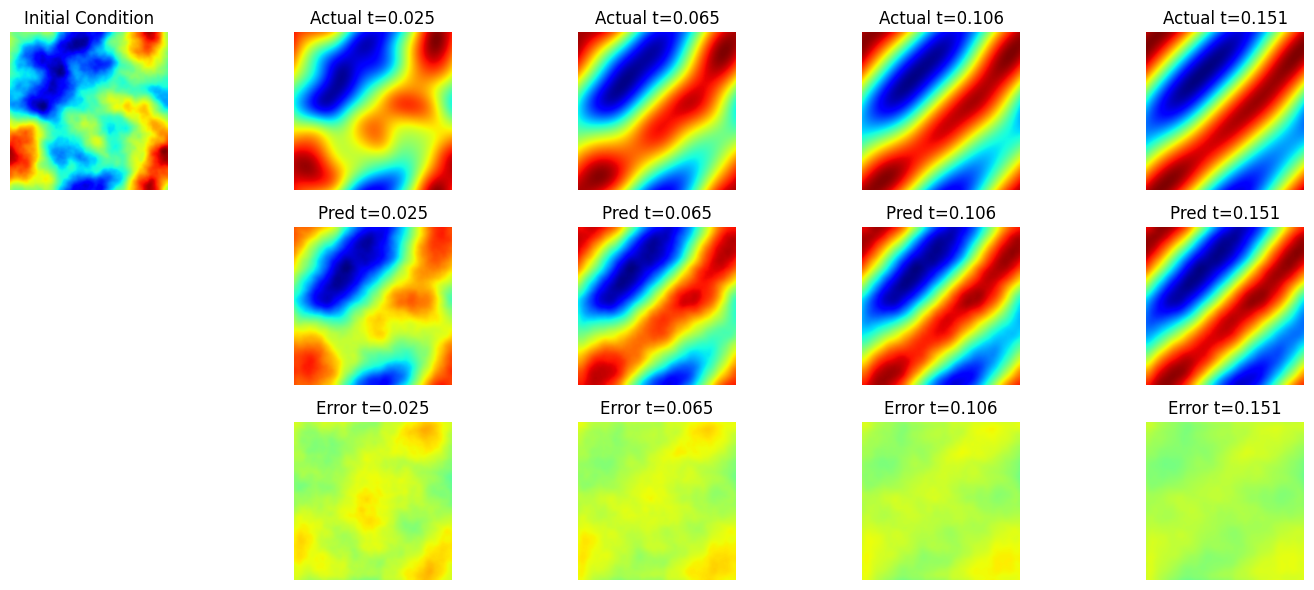

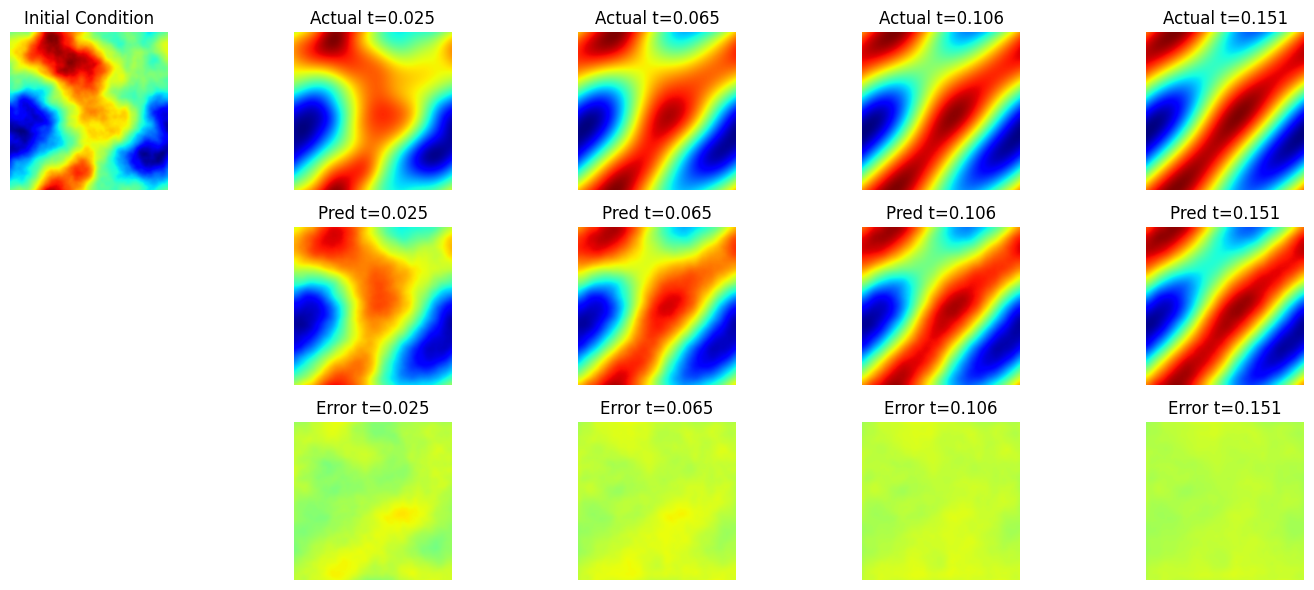

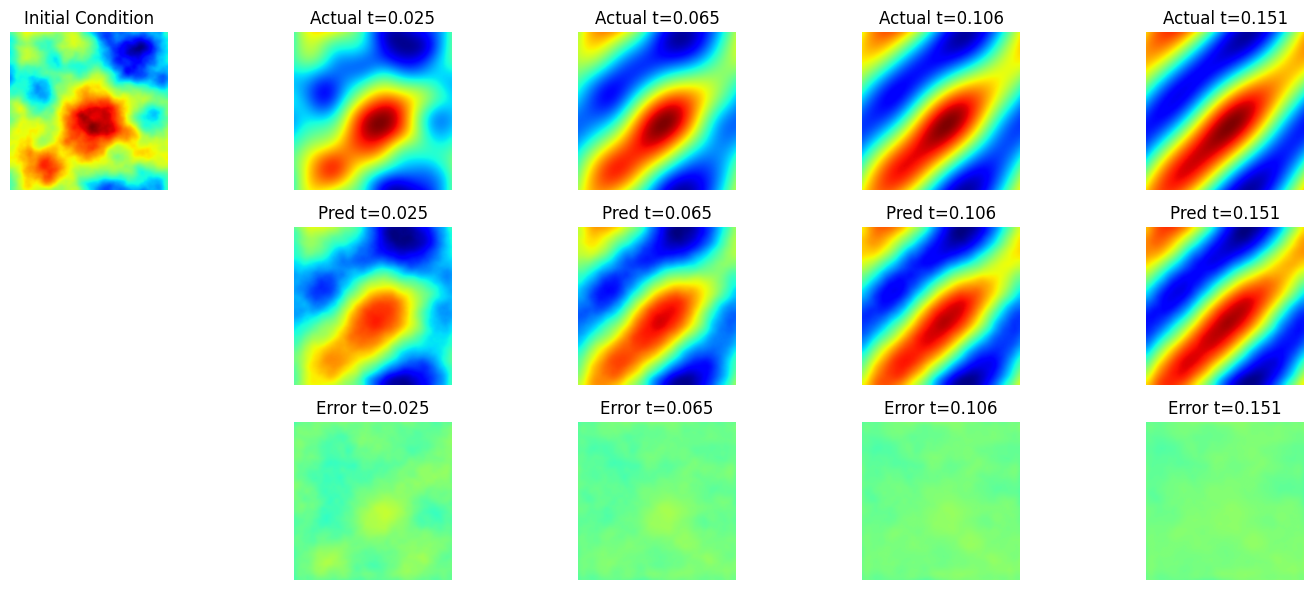

In [13]:
for i in [0,1,2]:

    with torch.no_grad():
        # 테스트셋 첫 배치에서 첫 번째 샘플 선택
        x_sample = x_test[i].unsqueeze(0).cuda()   # (1, s, s, 3)
        y_sample = y_test[i].unsqueeze(0).cuda()   # (1, s, s, record_steps)
        out_sample = model_FNO(x_sample)           # (1, s, s, record_steps)

    # CPU로 가져오기
    y_np = y_sample[0].cpu().numpy()      # (s, s, record_steps)
    pred_np = out_sample[0].cpu().numpy() # (s, s, record_steps)

    # subplot으로 여러 시점 비교
    num_plots = 4
    indices = np.linspace(5, 30, num_plots, dtype=int)

    fig, axs = plt.subplots(3, num_plots+1, figsize=(3*(num_plots+1), 6))

    ###########################
    # 1) 첫 번째 열: 초기조건
    ###########################
    init_a = x_sample[0, :, :, 0].cpu().numpy()  # (s, s)

    axs[0, 0].imshow(init_a, cmap='jet')
    axs[0, 0].set_title(f"Initial Condition")
    axs[0, 0].axis('off')

    s_h, s_w = y_np.shape[:2]  # s, s
    white_image = np.ones((s_h, s_w), dtype=np.float32)  # 1.0 -> 흰색
    axs[1, 0].imshow(white_image, cmap='gray', vmin=0.0, vmax=1.0)
    axs[1, 0].set_title("")   # 제목 제거
    axs[1, 0].axis('off')

    axs[2, 0].imshow(white_image, cmap='gray', vmin=0.0, vmax=1.0)
    axs[2, 0].set_title("")   # 제목 제거
    axs[2, 0].axis('off')


    ###########################
    # 2) 2열부터: 선택된 시점
    ###########################
    for i, idx in enumerate(indices):
        col = i + 1  # 열 인덱스 (첫 열은 초기조건, 두 번째 열부터 시간 시점)

        # Determine global min and max for consistent color scaling across columns

        global_min = min(np.min(y_np[:, :, idx]), np.min(pred_np[:, :, idx]))
        global_max = max(np.max(y_np[:, :, idx]), np.max(pred_np[:, :, idx]))

        # 실제 해
        axs[0, col].imshow(y_np[:, :, idx], cmap='jet', vmin=global_min, vmax=global_max)
        axs[0, col].set_title(f"Actual t={t[idx]:.3f}")
        axs[0, col].axis('off')

        # 예측 해
        axs[1, col].imshow(pred_np[:, :, idx], cmap='jet', vmin=global_min, vmax=global_max)
        axs[1, col].set_title(f"Pred t={t[idx]:.3f}")
        axs[1, col].axis('off')


        # 차이
        axs[2, col].imshow(y_np[:, :, idx]-pred_np[:, :, idx], cmap='jet', vmin=global_min, vmax=global_max)
        axs[2, col].set_title(f"Error t={t[idx]:.3f}")
        axs[2, col].axis('off')

    plt.tight_layout()
    plt.show()